# Run simple oral model with oral daily dosing

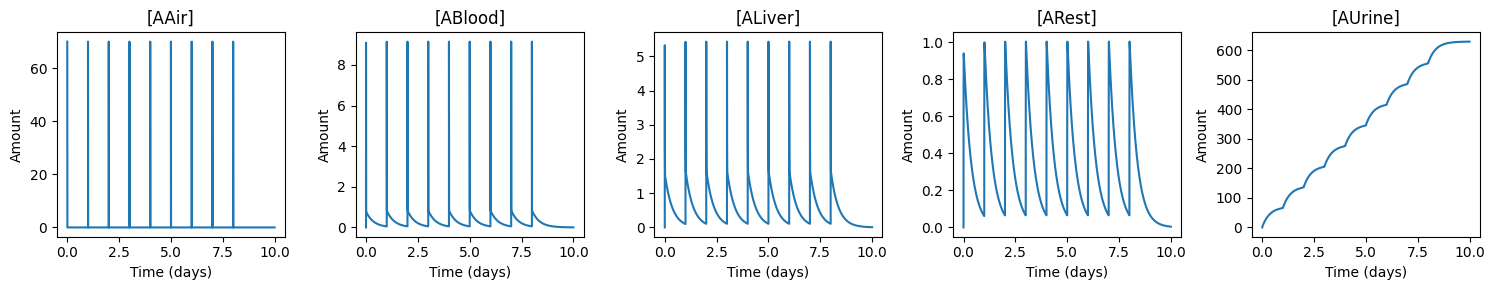

In [43]:
import math
import tellurium as te
import matplotlib.pyplot as plt

fn_ant = '../models/simple_inhalation/simple_inhalation.ant'

# Specify the input
input_id = 'AAir'

# BW and dosing
bw = 70
daily_intake = 1 * bw
days_of_exposure = 9
days_after_exposure = 1

# Output evaluation resolution (minutes)
evaluation_resolution = 3600

# Load the PBK model
rr_model = te.loada(fn_ant)

# Set physiological parameters
rr_model.BW = bw

# Create a repeating daily inhalation dosing
event_id = f"inhalation_daily_exposure"
rr_model.addEvent(event_id, False, f"time % 24 == 0 && time < {24 * days_of_exposure}", False)
rr_model.addEventAssignment(event_id, input_id, f"{input_id} + {daily_intake}", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
num_days = days_of_exposure + days_after_exposure
results = rr_model.simulate(0, 24 * num_days, evaluation_resolution * 24 * num_days + 1)

# Helper function for plotting simulation results
def plotSimulationResults(res, selections, ncols=5):
    nrows = math.ceil((len(selections) - 1)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    for ax in axes:
        ax.set(xlabel='Time (days)') 
    labels = selections
    for i in range(1, len(selections)):
        sid = selections[i]
        axes[i-1].plot(res['time'] / 24, res[sid])
        axes[i-1].set(ylabel=f"Amount", title=labels[i])
    for j in range(len(selections), nrows*ncols + 1):
        fig.delaxes(axes[j-1])
    fig.tight_layout()

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)

# Continuous dosing events

['time', '[ABlood]', '[ALiver]', '[ARest]', '[AUrine]', '[AAir]']


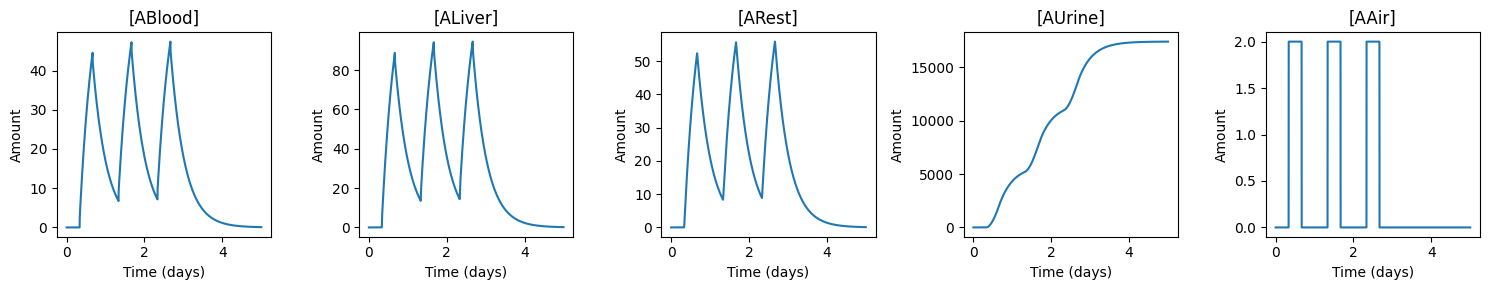

In [44]:
# BW and dosing
air_concentration = 2 # ug/L
days_of_exposure = 3
days_after_exposure = 2

# Output evaluation resolution (minutes)
evaluation_resolution = 3600

# Load the PBK model
rr_model = te.loada(fn_ant)

# Set physiological parameters
rr_model.BW = bw

# Make sure inhalation is not constant and does not have boundary conditions
rr_model.setInitAmount(input_id, 0)
rr_model.setConstant(input_id, False)
rr_model.setBoundary(input_id, True)

# Create an event for each of the time-dose tuples
eid_up = f"inhalation_daily_exposure_up"
rr_model.addEvent(eid_up, False, f"time % 24 > 8 && time % 24 < 16 && time < {24 * days_of_exposure}", False)
rr_model.addEventAssignment(eid_up, input_id, f"{air_concentration} * Air", False)
eid_down = f"inhalation_daily_exposure_down"
rr_model.addEvent(eid_down, False, f"time % 24 < 8 || time % 24 > 16 && time < {24 * days_of_exposure}", False)
rr_model.addEventAssignment(eid_down, input_id, "0", False)
rr_model.regenerateModel(True, True)

# Simulate the PBPK model
num_days = days_of_exposure + days_after_exposure
rr_model.timeCourseSelections = rr_model.timeCourseSelections + ['[AAir]']
print(rr_model.timeCourseSelections)
results = rr_model.simulate(0, 24 * num_days, evaluation_resolution * 24 * num_days + 1)

# Plot the results
plotSimulationResults(results, rr_model.timeCourseSelections)
